# **Aprendizaje Automático**. Práctica Entregable 3.

## OBJETIVOS
El objetivo de esta práctica es diseñar y entrenar una red neuronal para limpiar el fondo de imágenes de textos que contienen diferentes patrones de ruido. Para ello, se pide implementar y entrenar un **autoencoder convolucional**. Para el entrenamiento se proporciona un dataset de imágenes de entrenamiento y un dataset de validación. El estudiante tendrá que:


1. Diseñar un autoencoder convolucional que tome como entrada una imagen con ruido y devuelva la misma imagen con el fondo limpio de ruido. 
2. Entrenar el autoencoder usando el dataset de entrenamiento proporcionado.
3. Testear el autoencoder usando el dataset de validación y reportar MSE global, MSE por imagen, y el resultado reconstruido de cada imagen del set de validación.
4. (Opcional) Diseñar un autoencoder que realice la operación inversa: eliminar el texto y mantener el ruido de fondo. Se reportarán las imágenes del resultado de la reconstrucción. 

*Importante: El problema que vais a resolver en esta práctica es bastante complejo por lo que no se esperan resultados perfectos. Sí se espera que el texto de la imagen reconstruida sea legible. Se recomienda empezar con una arquitectura lo más sencilla posible y poco a poco ir añadiendo complejidad si es necesario. *

Entregables: 

* El código de la práctica en un archivo llamado `practica3_[apellidos]_[nombre].ipynb` , por ejemplo `practica3_garces_garcia_elena.ipynb`, que se pueda ejecutar para entrenar el modelo que presentéis. Lo tenéis que implementar directamente en este Google Colab, empezando al final de este enunciado. Para entregarlo, lo podéis descargar desde `File->Download->Download .ipynb`. Vuestro código tiene que incluir todo lo habitual para este tipo de problemas  
(**observar que la división de entrenamiento y test ya está dada**): diseño de una arquitectura, un bucle de entrenamiento, gráficas de los valores de la loss a lo largo de un entrenamiento, métricas MSE en el test set, etc.


* Una memoria en formato .pdf que contenga los apartados: Descripción del problema. Solución propuesta. Aquí debes describir la red que propones (número de capas, funciones de activación, etc.). Resultados y Evaluación. Incluye alguna figura con los resultados que obtienes, y comenta los fallos que pueda hacer vuestra red en el conjunto de test. Describe también qué efectos producen los hiperparámetros de tu modelo (por ej., qué pasa cuando subes el learnig rate, o el batch size). También puedes comentar diferentes arquitecturas que hayas probado, y cual era el resultado.



La fecha máxima de entrega será domingo 9 de enero a las 23.59. Se va ha habilitar una entrega por Aula Virtual en la que hay que entregar el Notebook en formato .npynb y la memoria en formato .pdf.






## AUTOENCODER CONVOLUCIONAL

El autoencoder convolucional es un concepto que no se ha visto en clase, aunque conoceis casi todas las herramientas para implementarlo. Igual que los autoencoders densos, el AE convolucional tiene un encoder y un decoder. 

**Encoder**

El modulo de encoder será equivalente al ya visto en prácticas anteriores. Cada capa convolucional podrá ir seguida de una capa de max-pooling para reducir su dimensionalidad.

**Decoder**

El modulo de decoder es algo NUEVO. El decoder tiene la misión de reconstruir la imagen de entrada a partir de un espacio latente más compacto, o de otra dimensionalidad que la entrada. El resultado del decoder tiene que ser una imagen del mismo tamaño que la imagen de entrada.




### Transposed Convolutions

Para poder implementar el decoder convolucional necesitais conocer dos módulos nuevos: 
1. El módulo de "convolución traspuesta" [``` nn.ConvTranspose2d ```](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#convtranspose2d) es el inverso al módulo de convolución que ya conoceis. Contiene un conjunto de **filtros que se aprenden** para aumentar la resolución de la entrada. 

> **Consejo importante**: En el módulo `ConvTranspose2d`, el argumento `padding` agrega `dilation * (kernel_size - 1) - padding` ceros de relleno a ambos lados de la entrada. Esto se establece para que cuando `Conv2d` y  `ConvTranspose2d` se inicialicen con los mismos parámetros, sean inversos entre sí en lo que respecta a las formas de entrada y salida. **Sin embargo**, cuando `stride > 1`, `Conv2d` mapea múltiples entradas a la misma variable de salida. Para resolver esta ambigüedad se usa el parámetro `output_padding`, que aumenta la salida en el tamaño especificado para el cálculo interno, pero no cambia el tamaño del vector de salida.



2. El módulo de upsampling [```UpsamplingBilinear2d ```](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingBilinear2d.html#torch.nn.UpsamplingBilinear2d). Es el inverso del módulo de max pooling. Simplemente escala la entrada al tamaño especificado utilizando interpolación bilineal. Este módulo no contiene filtros que se puedan aprender. No se recomienda usarlo ya que no es muy efectivo.


In [1]:
# Importa las librerías que vamos a necesitar
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

import colorlover as cl
from   plotly import graph_objs as go
from   plotly import offline
import plotly.express as px


# librería especial para visualizar resultados en tablas
!pip install -q mediapy
import mediapy as media

## EJERCICIO: LIMPIEZA DEL FONDO EN IMÁGENES DE TEXTOS

A continuación se proporcionan algunas funciones de utilidad

In [2]:
# Importa las librerías que vamos a necesitar
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import glob 
import cv2
from torchsummary import summary
# librería especial para visualizar resultados en tablas
!pip install -q mediapy
import mediapy as media

In [3]:
# Para usar la GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Fija las semillas de los numeros aleatorios
torch.manual_seed(50)
torch.cuda.manual_seed(50)

#### Descargar el dataset

In [5]:
!wget https://www.dropbox.com/s/zpdm2ls6h91mvib/scan_noisy.zip

--2022-01-08 18:36:11--  https://www.dropbox.com/s/zpdm2ls6h91mvib/scan_noisy.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zpdm2ls6h91mvib/scan_noisy.zip [following]
--2022-01-08 18:36:11--  https://www.dropbox.com/s/raw/zpdm2ls6h91mvib/scan_noisy.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6738b1f669535fad80d79bc731.dl.dropboxusercontent.com/cd/0/inline/BdYkRZT1-4S_LtM3GCpQcI5yDORt89UMTkM2mN3-iAkYZg3OpryTijcCUIRiF1fPn_Zj45VvBlWB6XozuMUIO1KFgH4rhk7ri8-u7ZQcMRYKS3lSw0fATwZo-rpPC25j8fRQQlLuWr_xA2_mCkEUmDXF/file# [following]
--2022-01-08 18:36:11--  https://uc6738b1f669535fad80d79bc731.dl.dropboxusercontent.com/cd/0/inline/BdYkRZT1-4S_LtM3GCpQcI5yDORt89UMTkM2mN3-iAkYZg3OpryTijcCUIRiF1fPn_Zj45VvBlWB6XozuMU

In [6]:
!unzip scan_noisy.zip

Archive:  scan_noisy.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
  inflating: train/107.png           
  inflating: train/108.png           
  inflating: train/11.png            
  inflating: train/110.png           
  inflating: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
  inflating: train/116.png           
  inflating: train/117.png           
  inflating: train/119.png           
  inflating: train/12.png            
  inflating: train/120.png           
  inflating: train/122.png           
  inflating: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  inflating: train/128.png           
  inflating: train/129.png           
  inflating: train/131.png           
  inflating: train/132.png           
  inflating: train/134.png           
  inf

#### Sugerencia de carga de datos (podéis hacer otra cosa)

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, load_train=True):

        if load_train:
            X_IMAGES = glob.glob('train/*.png')
            Y_IMAGES = glob.glob('train_cleaned/*.png')
        else:
            X_IMAGES = glob.glob('validation/*.png')
            Y_IMAGES = glob.glob('validation_cleaned/*.png')        

        def load_image(path):
            # OJO! teneis que decidir cómo gestionar el tamaño de los datos de 
            # entrada (no son todos iguales). Esto es crítico en **entrenamient** porque
            # el batch tiene que contener un conjunto de imagenes del mismo tamaño.
            #  Ideas: recortar o redimensionar  a tamaño fijo 
            image_list = np.zeros((len(path), 1, 256, 512), dtype='float32')
            for i, fig in enumerate(path):
                img = cv2.imread(fig, cv2.IMREAD_GRAYSCALE) 
                # una posible solución es redimensionar las imágenes a un tamaño fijo con el código de abajo                
                x = cv2.resize(img, dsize=(512, 256)).astype('float32')  
                x = x / 255.0                
                image_list[i,0,] = x            
            return image_list              
      
        self.x = load_image(X_IMAGES)
        self.y = load_image(Y_IMAGES)    
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):        
        noisy = self.x[idx]
        clean = self.y[idx]
        return noisy, clean

train_loader = torch.utils.data.DataLoader(CustomDataset(), batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(CustomDataset(load_train=False), batch_size=4, shuffle=True)

#### Código que muestra el error en el set de validación. A completar con la estimación del modelo entrenado. 

noisy,0.01279856450855732,0.028630925342440605,0.03420178219676018,0.02036459930241108

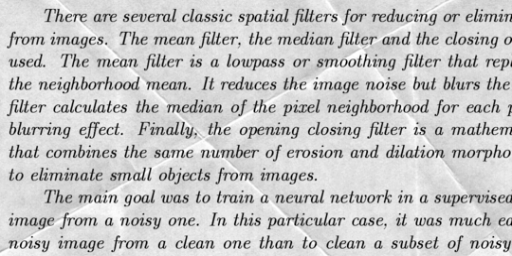
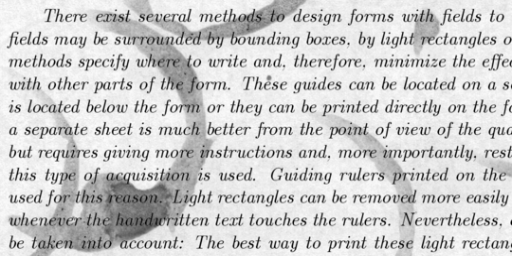
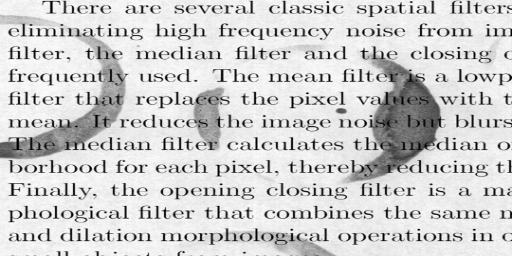
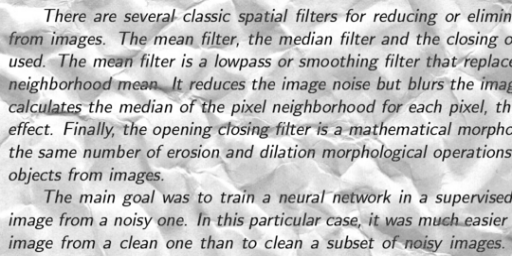

clean,,,,

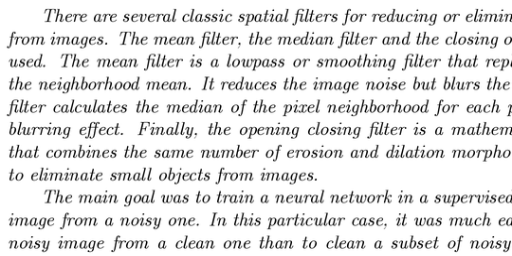
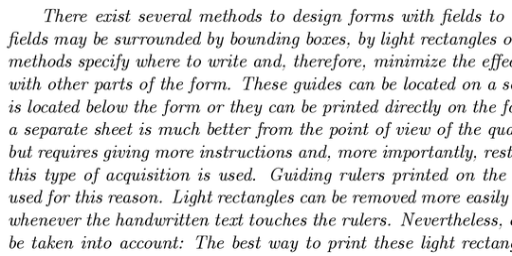
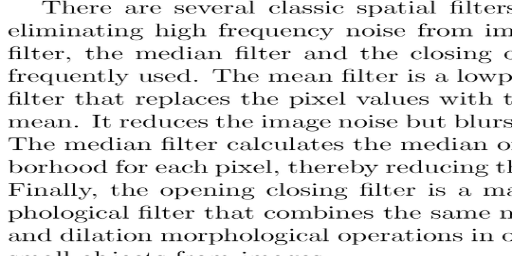
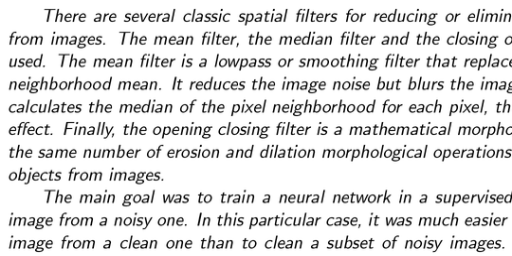

Media MSE 0.023998968


In [8]:
# Mostrar los datos de validación y el error
def display_images_mediapy(imgs, column_title=None, label="", n=4):
    #
    # imgs: N, 1, ancho, alto
    # 
    imgs = imgs.permute((0,2,3,1)) # N, ancho, alto, 1
    im_input = imgs.cpu().data
    # si no especifica el número, muestra n=4, si n=None muestra todas
    if n is None: n = len(imgs)
    if imgs is not None:       
        media.show_images([image for idx, image in enumerate(im_input) if idx < n],
                          ylabel=label, titles=column_title)  

criterion = nn.MSELoss()
# Cargar un batch de datos, visualizarlo y mostrar el error
for data in val_loader:    
    noisy, clean = data
    # Calcula MSE para cada par de imagenes
    mse = []
    for i in range(len(noisy)):
        loss = criterion(noisy[i], clean[i])
        mse.append(loss)   
    display_images_mediapy(noisy, label="noisy", column_title=mse)
    display_images_mediapy(clean, label="clean")

# Calcula error global
loss = criterion(noisy, clean)
print("Media MSE", loss.numpy())



# AUTOENCODER CONVOLUCIONAL

In [9]:
import torch.nn as nn
import torch.nn.functional as F
debug = True

class ConvAutoencoderDummy(nn.Module):
    def __init__(self):
        super(ConvAutoencoderDummy, self).__init__()
        #super(ConvAutoencoderDummy, self).__init__()
       
       #Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = torch.sigmoid(self.t_conv3(x))
      
                
        return x

# initialize the NN
model = ConvAutoencoderDummy().to(device)
print(model)
summary(model, (1,512,256))
# Testear que el modelo funciona usando un vector aleatorio 
a = torch.rand((16,1,256,256)).to(device)
x = model(a);
print("El modelo devuelve un vector del mismo tamaño que la entrada", x.shape == a.shape)
assert(x.shape == a.shape)

ConvAutoencoderDummy(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 256]             160
         MaxPool2d-2         [-1, 16, 256, 128]               0
            Conv

In [10]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

# BUCLE DE ENTRENAMIENTO

epoch [1/500], loss:0.0698
epoch [2/500], loss:0.0621
epoch [3/500], loss:0.0566
epoch [4/500], loss:0.0571
epoch [5/500], loss:0.0618
epoch [6/500], loss:0.0491
epoch [7/500], loss:0.0439
epoch [8/500], loss:0.0403
epoch [9/500], loss:0.0405
epoch [10/500], loss:0.0423
epoch [11/500], loss:0.0376
epoch [12/500], loss:0.0386
epoch [13/500], loss:0.0351
epoch [14/500], loss:0.0323
epoch [15/500], loss:0.0400
epoch [16/500], loss:0.0379
epoch [17/500], loss:0.0374
epoch [18/500], loss:0.0375
epoch [19/500], loss:0.0390
epoch [20/500], loss:0.0371
epoch [21/500], loss:0.0309
epoch [22/500], loss:0.0345
epoch [23/500], loss:0.0375
epoch [24/500], loss:0.0339
epoch [25/500], loss:0.0350
epoch [26/500], loss:0.0313
epoch [27/500], loss:0.0351
epoch [28/500], loss:0.0323
epoch [29/500], loss:0.0274
epoch [30/500], loss:0.0299
epoch [31/500], loss:0.0314
epoch [32/500], loss:0.0347
epoch [33/500], loss:0.0280
epoch [34/500], loss:0.0280
epoch [35/500], loss:0.0309
epoch [36/500], loss:0.0266
e

Text(0, 0.5, 'loss')

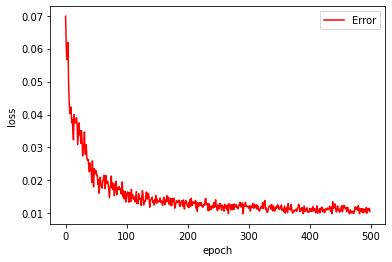

In [11]:
# Entrenar denoising autoencoder
num_epochs =500
losses = []
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:    
        noisy, clean = data  
        noisy=noisy.to(device)
        clean=clean.to(device) 
        # ===================forward=====================        
        output = model(noisy)  
        loss = criterion(output, clean.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # =========================================================================
    losses.append(loss.item())
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')



print("Resultado de la reconstruccion con Autoencoder Básico")
print("\tNumero de iteraciones, ", num_epochs)
plt.plot(range(num_epochs), losses, color='red', label="Error")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')



# TESTEAR CON CONJUNTO DE VALIDACIÓN

output,0.007693664636462927,0.008902141824364662,0.010290845297276974,0.010684208013117313

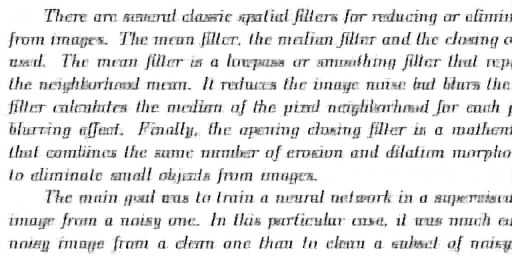
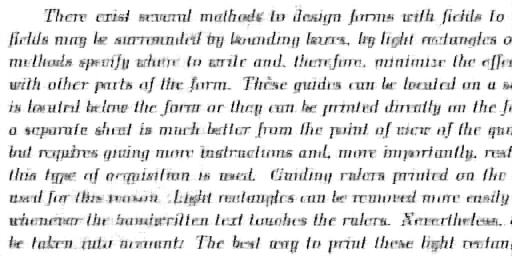
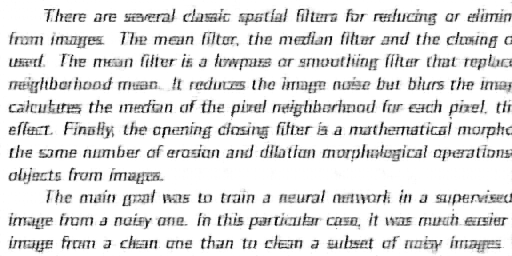
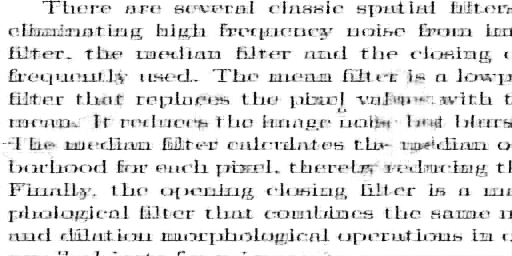

noisy,,,,

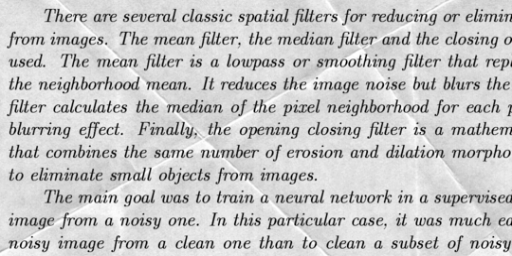
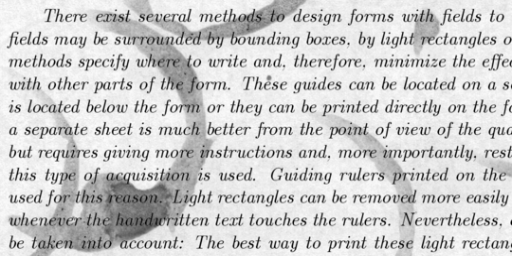
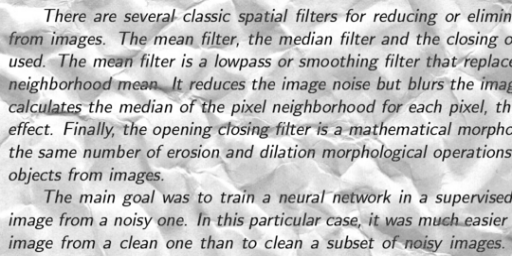
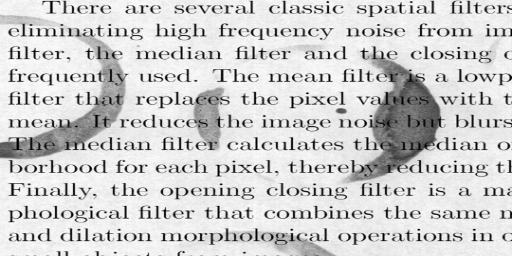

clean,,,,

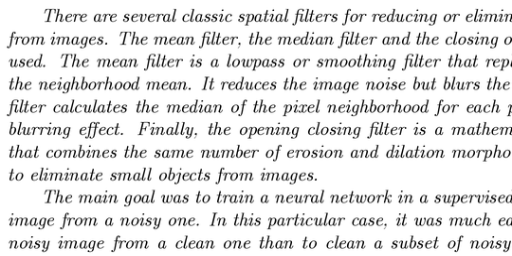
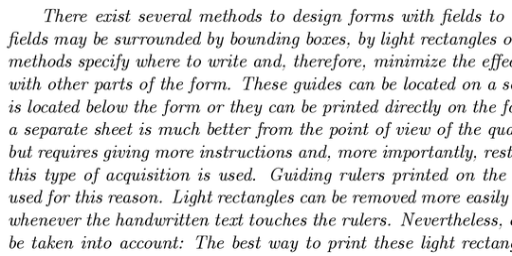
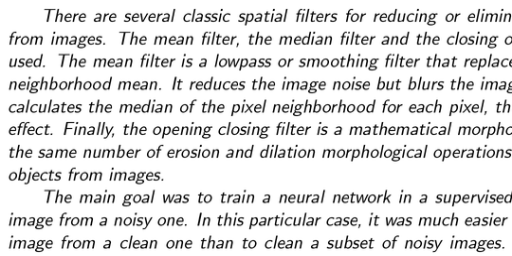
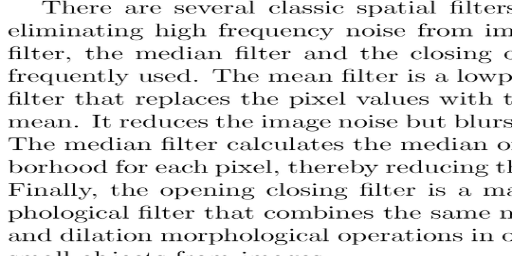

Media MSE tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)


In [13]:
# Cargar un batch de datos, visualizarlo y mostrar el error
for data in val_loader:    
    noisy, clean = data
    noisy=noisy.to(device)
    clean=clean.to(device)  
    output = model(noisy)  
    # Calcula MSE para cada par de imagenes
    mse = []
    for i in range(len(output)):
        loss = criterion(output[i], clean[i])
        mse.append(loss) 
    display_images_mediapy(output, label="output", column_title=mse)
    display_images_mediapy(noisy, label="noisy")
    display_images_mediapy(clean, label="clean")

# Calcula error global
loss = criterion(output, clean)
print("Media MSE", loss)